# Modeling and Predicting Chart Difficulties with Machine Learning

Svitlana Glibova,  
January 2021 Flatiron Data Science Cohort

## Business Understanding
### Domain Introduction
Stepmania is an open-source software designed to support many styles of rhythm
game play, but one of its most widely-used formats is for 4-panel “dance games”
(well-known “dance game” examples are Dance Dance Revolution and In The Groove,
but these are specifically-licensed games by Konami and Roxor). The software was
released in 2001 and has since been updated through version 5.3 - the concept behind
this software is to allow players to play a “DDR-like” game with virtually boundless
customizations, including custom charts (arrow patterns for songs).  

### Business Problem
The problem that I aim to solve is using exploratory data analysis and statistical learning
to help establish a standardization for song chart difficulty ratings based on various
features of the chart, for example BPM, duration, and quantity of technical elements.

### Motivation  
While there are many respectable step-artists with expertise in their domains, there has
not been an official and standardized rating system for song difficulties - it is not
uncommon to see players in conversation over whether a song should be “re-rated”
due to various features of its chart. Creating a method of standardization will help
examine which features are the most important in determining difficulty and help
step-artists remove the intuitive/guesswork element from rating their own charts.
The community of rhythm game players is surprisingly large and the amount of
dedication that this community has poured into creating an open-source rendition of
rhythm games is incredible. This software is free and is used for tournament play and
for writing charts and is a staple to any outside-of-arcade dance game player, and is
sometimes employed in small, local arcades as well.

## A Brief Overview of StepMania and "Dance Games"

## Data Understanding

### Data Collection 


### Chart Features
See [this link](data/feature_dictionary.txt) for a full explanation of each feature that was extracted from the song files.

### Why is the data being split this way?  

With some domain understanding, I thought that it would be important to distinguish between 'stamina' and 'tech' data. 

*'Tech'* refers to songs that are perhaps more technically challenging, requiring the player to unpack more complex arrow patterns and to generally have more lateral movement. The song lengths are on the shorter side relative to songs found across both styles.  

*'Stamina'* song difficulties and lengths can range much higher, therefore the outliers are going to be on a different scale than those of tech. With much longer songs, the patterns are less complex but require much more consolidation of movement from the player and test endurance.  

Below, notice the large differences between the mean and max differences of features between the datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,\
                            roc_curve, auc, classification_report, log_loss, mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA


from xgboost import XGBClassifier, XGBRegressor


import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\svett\anaconda3\envs\learn-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\svett\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\svett\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
##display all dataframe columns
pd.set_option('display.max_columns', None)

tech = pd.read_csv('data/not_stam.csv')
stam = pd.read_csv('data/stam.csv')

In [3]:
from src.data_cleaning import data_cleaner

## Exploratory Data Analysis

To see a full breakdown of data exploration, filling NaN values, and methods for removing outliers, visit the [EDA Notebook]('eda_notebook.ipynb').  
### Motivation for removing outliers with this method:  

### 'Tech' Data

In [4]:
tech_df = data_cleaner(tech)

Initialized Tech DataFrame with 4808 rows.

Removing outliers and filling NaN values...

The songs in this Tech dataset are up to 164.002 seconds (2.733 minutes) long.
The songs in this Tech dataset have up to 826 steps.
The songs in this Tech dataset have a max bpm weighted average up to 175 bpm.
The songs in this Tech dataset have up to 21 bpm changes.
The songs in this Tech dataset are up to 6.387 NPS.

Returning cleaned Tech DataFrame with 3236 rows and 32 columns.


In [5]:
tech_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,rating,stream_log_transform
count,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.00000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000
mean,124.939581,375.223733,69.380408,133.446658,146.505247,120.169037,134.462669,1.671508,3.015767,5.533509,3.043281,3.227578,1.327000,3.322468,18.596724,0.125773,0.04759,34.366811,5.962299,2.838690,7.381026,13.055315,3.409147,2.342707,2.948702,0.772868,2.148331,6.582200,0.459202
std,14.597848,215.282927,12.534894,20.607616,39.719405,31.216151,21.804486,3.725007,1.711568,3.305625,1.726194,1.845572,0.797263,2.091759,19.482935,1.182276,0.84001,34.330774,14.663473,7.772694,7.661243,14.004427,3.927484,3.964406,3.433064,3.835169,4.900897,3.514208,0.889537
min,16.971412,30.000000,7.000000,58.741500,90.000000,4.250000,47.000000,0.000000,0.270833,0.416667,0.270833,0.000000,0.094991,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,115.200000,183.000000,61.000000,122.097153,125.999992,105.000000,124.999992,0.000000,1.486950,2.666667,1.498501,1.600000,0.662269,1.525000,5.000000,0.000000,0.00000,8.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,124.800000,369.000000,69.000000,130.000000,135.000000,128.000000,130.000000,0.000000,3.012753,5.000000,3.037832,3.216667,1.223296,3.227083,13.000000,0.000000,0.00000,25.000000,0.000000,0.000000,5.000000,9.000000,2.000000,1.000000,2.000000,0.000000,0.000000,7.000000,0.000000
75%,134.400000,555.250000,76.000000,148.000000,159.000000,140.000000,150.000000,2.000000,4.460403,8.190625,4.498397,4.800000,1.895284,4.875000,27.000000,0.000000,0.00000,52.000000,4.000000,2.000000,11.000000,18.000000,5.000000,3.000000,4.000000,0.000000,1.000000,10.000000,0.000000
max,164.001545,826.000000,120.000000,175.000000,540.000000,175.000000,228.000000,21.000000,6.375353,34.000000,7.626016,9.250000,7.248217,12.800000,180.000000,32.000000,40.00000,291.000000,211.000000,116.000000,61.000000,145.000000,47.000000,41.000000,25.000000,65.000000,36.000000,14.000000,3.583519


### 'Stamina' Data

In [6]:
stam_df = data_cleaner(stam, is_stamina = True)

Initialized Stamina DataFrame with 2926 rows.

Removing outliers and filling NaN values...

The songs in this Stamina dataset are up to 7089.862 seconds (118.164 minutes) long.
The songs in this Stamina dataset have up to 5096 steps.
The songs in this Stamina dataset have a max bpm weighted average up to 216.0 bpm.
The songs in this Stamina dataset have up to 4 bpm changes.
The songs in this Stamina dataset are up to 11.289 NPS.

Returning cleaned Stamina DataFrame with 2287 rows and 41 columns.


In [7]:
stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating,stream_log_transform
count,2287.000000,2287.000000,2287.000000,2287.000000,2.287000e+03,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000
mean,261.873897,1727.597726,178.225186,165.005359,5.412749e+03,162.550080,164.909974,0.174464,6.701975,10.505899,6.712772,7.288617,3.006128,8.554097,20.681242,0.110188,0.067337,69.878006,11.190206,3.403148,5.334062,13.106690,3.219502,1.427634,4.286839,0.002624,61.829908,7.782685,23.142545,11.579264,8.044649,8.771316,38.902492,15.870039,104.454307,13.754685,12.228247,3.263298
std,101.519229,929.899552,69.398979,28.084973,1.448036e+05,31.267703,28.847299,0.704128,2.514109,3.441717,2.512291,3.279981,1.270053,3.928374,30.522231,1.439694,0.580234,76.948321,43.273815,9.208870,9.494364,21.469892,6.255070,3.571405,7.136583,0.051164,58.006429,5.518401,23.145074,14.365454,8.909119,5.512151,26.696221,16.120614,56.500021,12.154812,3.857867,1.742911
min,61.286375,20.000000,31.000000,76.000000,7.600000e+01,43.500000,76.000000,0.000000,0.106967,0.525000,0.125000,0.000000,0.052933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.235702,2.000000,2.000000,1.000000,3.000000,0.577350,1.000000,0.000000
25%,192.000000,1047.000000,121.000000,141.081000,1.430000e+02,140.000000,141.081000,0.000000,5.258994,9.200000,5.278708,5.287500,2.210102,5.750000,1.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,4.000000,10.000000,4.500000,4.359395,5.000000,23.000000,7.733333,68.000000,7.550956,11.000000,2.397895
50%,255.085714,1644.000000,178.000000,174.000000,1.740000e+02,173.000000,174.000000,0.000000,6.979552,11.533333,6.981865,6.675000,3.123474,9.200000,10.000000,0.000000,0.000000,49.000000,0.000000,0.000000,2.000000,5.000000,1.000000,0.000000,2.000000,0.000000,50.000000,6.000000,15.000000,6.392857,4.359395,7.000000,30.000000,9.875000,83.000000,9.633770,13.000000,3.912023
75%,314.202169,2310.000000,218.000000,180.004000,1.803560e+02,180.000000,180.004000,0.000000,8.473098,12.666667,8.477924,9.545000,3.879434,11.666667,27.000000,0.000000,0.000000,97.500000,3.000000,2.000000,7.000000,17.000000,4.000000,1.000000,5.000000,0.000000,96.000000,9.000000,31.000000,13.430556,9.073772,10.000000,47.000000,18.000000,135.000000,15.754515,15.000000,4.564348
max,736.363636,5065.000000,477.000000,216.000000,4.000000e+06,216.000000,216.000000,4.000000,11.285106,20.800667,11.285106,17.400000,8.155928,20.500000,289.000000,40.000000,9.000000,641.000000,501.000000,112.000000,108.000000,224.000000,63.000000,50.000000,97.000000,1.000000,303.000000,46.000000,192.000000,168.000000,107.480231,47.000000,236.000000,136.000000,422.000000,161.220346,27.000000,5.713733


### Visualization

In [32]:
from src.visualizer import distribution, scatter_correlation, box_plot, plot_resids

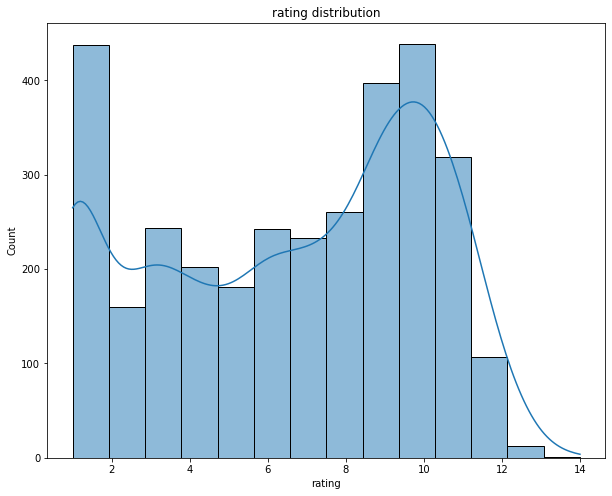

In [42]:
distribution(tech_df, 'rating')

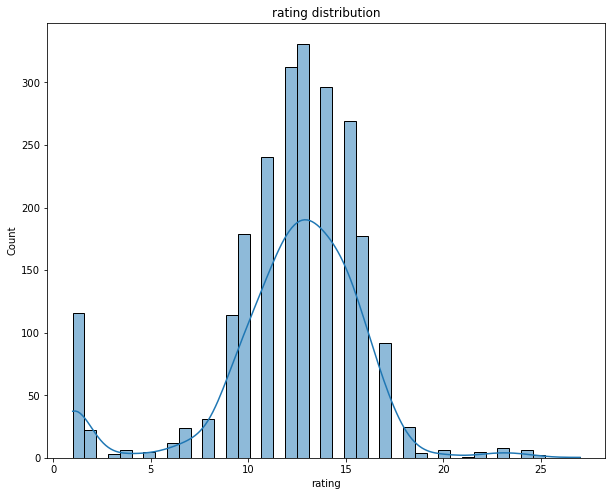

In [43]:
distribution(stam_df, 'rating')

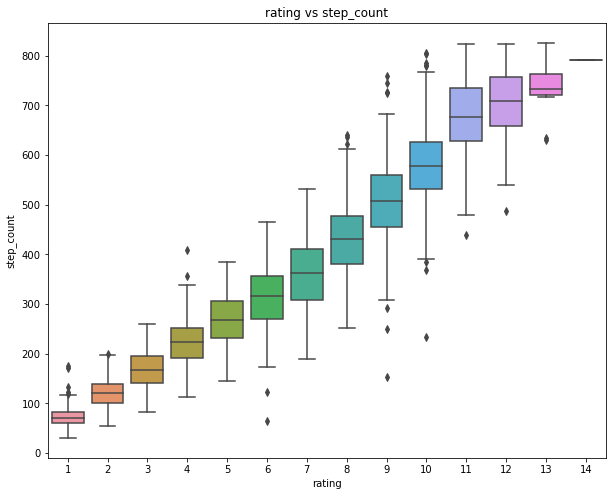

In [44]:
box_plot(tech_df, 'rating')

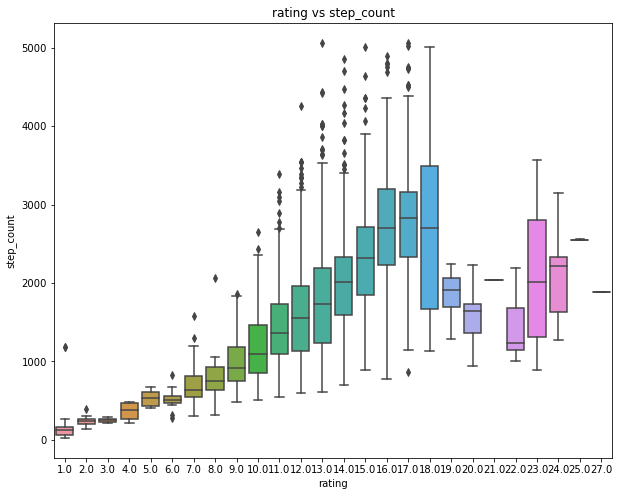

In [45]:
box_plot(stam_df, 'rating')

### Feature Engineering

## Modeling 

### First Simple Model - Linear Regression with Scaled Data

In [34]:
data = tech_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1)
target = tech_df['rating']

In [35]:
#train test split and a split of the train set for validation

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state = 42)

In [36]:
scaler = StandardScaler()
lr = LinearRegression()

X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

#scaling the full training set for cross validation
X_train_scaled = scaler.transform(X_train)

lr.fit(X_tr_scaled, y_tr)

LinearRegression()

In [37]:
print(f'LR | Train R^2: {lr.score(X_tr_scaled, y_tr)} \nLR | Test R^2: {lr.score(X_val_scaled, y_val)}')
print(f'LR | Val MSE: {mean_squared_error(y_tr, lr.predict(X_tr_scaled))} \nLR | Val MSE: {mean_squared_error(y_val, lr.predict(X_val_scaled))}')

LR | Train R^2: 0.9526777636299588 
LR | Test R^2: 0.9459640861156339
LR | Val MSE: 0.5879166268173219 
LR | Val MSE: 0.622801932214286


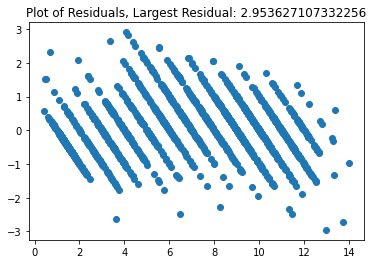

In [33]:
plot_resids(lr, X_tr_scaled, y_tr)

In [39]:
print(f"Cross Validation: {cross_val_score(lr, X_train_scaled, y_train, scoring = 'r2')}")
print(f"Cross Validation Mean: {cross_val_score(lr, X_train_scaled, y_train, scoring = 'r2').mean()}")

Cross Validation: [0.94632718 0.95351616 0.94935699 0.95146841 0.94741528]
Cross Validation Mean: 0.9496168069388544


### Iterations Upon First Simple Model

### Final Model

## Evaluation

### Metrics

### Visualization

## Summary / Conclusions

## Next Steps